# Introduction

In [1]:
# == Distribution from A. Fyon ==
import numpy as np
from scipy.stats import gamma
from utils import gamma_uniform_mean_std_matching
import matplotlib.pyplot as plt
import seaborn as sns
from stg import DICs, get_default_parameters
from matplotlib.patches import FancyArrowPatch
from matplotlib.ticker import ScalarFormatter
from stg import simulate_individual_t_eval, get_default_u0
import warnings
from utils import simulate_population_t_eval_multiprocessing
from tqdm import tqdm
from matplotlib.lines import Line2D

# == plotting setup ==
sns.set_context("notebook")
sns.set_style("white")
sns.set_palette("flare")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "0.9"
plt.rcParams["grid.linestyle"] = "solid"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
# Wrapper to simulate the population using multiprocessing
def simulate_population(population, U0 = get_default_u0(), T_EVAL = np.arange(3000, 4000, 0.5), PARAMS=get_default_parameters(), MAX_WORKERS=16):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        return np.asarray(simulate_population_t_eval_multiprocessing(simulate_individual_t_eval, population, U0, T_EVAL, PARAMS, MAX_WORKERS))[:, 1, :]

Simulating population (multiprocessing): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


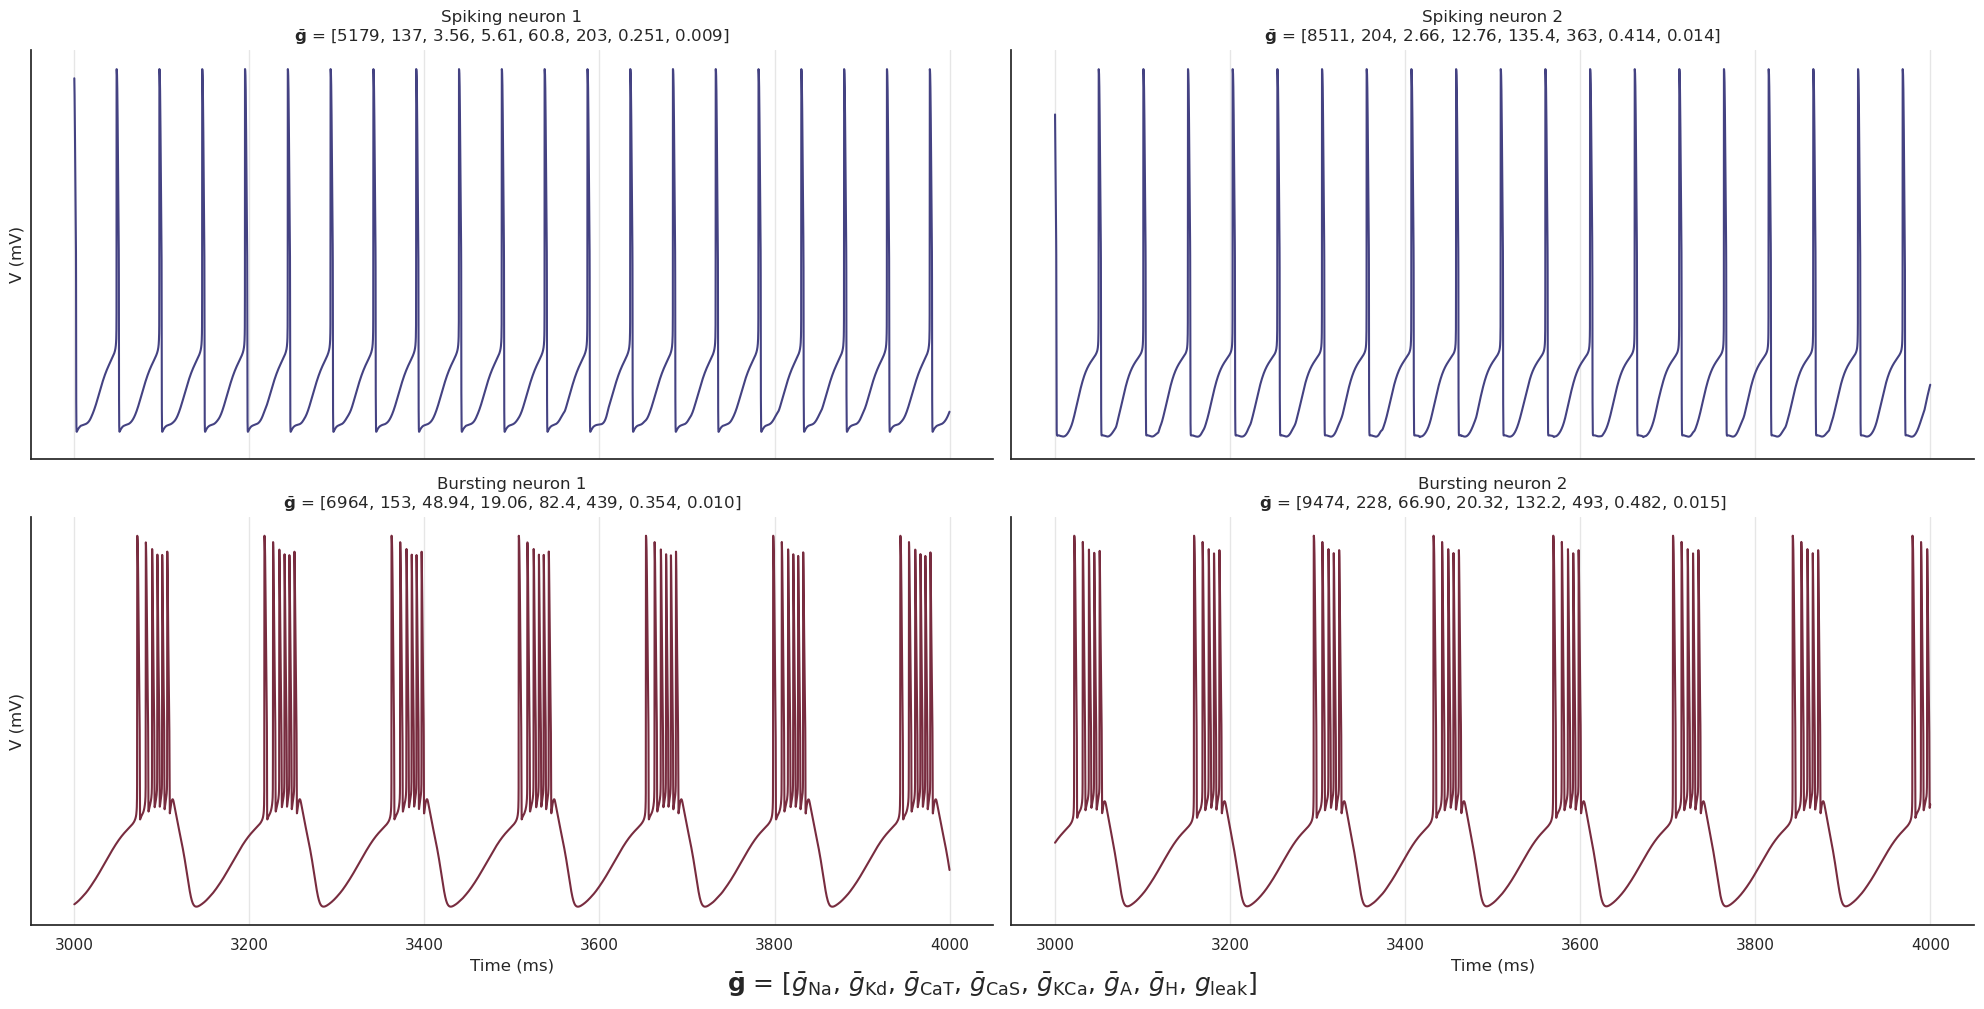

In [3]:
from stg import generate_neuromodulated_population
PALETTE = "icefire"

N = 2
V = -51.
g_u = 5.

# == Spiking neurons ==
g_s = 4.
spiking_population = generate_neuromodulated_population(N, V, g_s, g_u)

# == Bursting neurons ==
g_s = -5.
bursting_population = generate_neuromodulated_population(N, V, g_s, g_u)

# == Simulate the two first neurons of each population ==

population_to_simulate = np.vstack([spiking_population[:2], bursting_population[:2]])
T_EVAL = np.arange(3000, 4000, 0.1)
simulated_population = simulate_population(population_to_simulate, T_EVAL=T_EVAL)

# == Plot the results ==
# First plot is a 2x2 grid with the first row being the spiking neurons and the second row being the bursting neurons

colors = sns.color_palette(PALETTE, 2)
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < 2:
        color = colors[0]  # Spiking neurons
        g_bar = spiking_population[i % 2]
    else:
        color = colors[1]  # Bursting neurons
        g_bar = bursting_population[i % 2]
    ax.plot(T_EVAL, simulated_population[i], color=color)
    title = "Spiking" if i < 2 else "Bursting"
    title += f" neuron {i % 2 + 1}\n"
    title += r"$\bar{\mathbf{g}}$ = [" + ", ".join([f"{g_bar[0]:.0f}", f"{g_bar[1]:.0f}", f"{g_bar[2]:.2f}", f"{g_bar[3]:.2f}", f"{g_bar[4]:.1f}", f"{g_bar[5]:.0f}", f"{g_bar[6]:.3f}", f"{g_bar[7]:.3f}"]) + "]"
    ax.set_title(title)

    if i == 0 or i == 2:
        ax.set_ylabel("V (mV)")
    
    if i > 1:
        ax.set_xlabel("Time (ms)")

    ax.set_yticks([])

text = r"$\bar{\mathbf{g}}$ = [" + r"$\bar{g}_{\text{Na}}$, $\bar{g}_{\text{Kd}}$, $\bar{g}_{\text{CaT}}$, $\bar{g}_{\text{CaS}}$, $\bar{g}_{\text{KCa}}$, $\bar{g}_{\text{A}}$, $\bar{g}_{\text{H}}$, $g_{\text{leak}}$]"
plt.figtext(0.5, 0., text, ha="center", fontsize=18)
plt.tight_layout()

# save to pdf as "stg_behavior.pdf", need to expand the bottom margin to fit the text
plt.savefig("stg_behavior.pdf", bbox_inches='tight')
plt.show() # Figure 1

# Monte Carlo simulation

## Modeling the Uncertainty of Maximum Conductances

In [4]:
# maximal conductances distributions
g_bar_range_Na= [0, 6000.0]
g_bar_range_Kd= [0, 265]
g_bar_range_CaT= [0, 9.0]
g_bar_range_CaS= [0, 38]
g_bar_range_KCa= [0, 200]
g_bar_range_A= [0, 450.0]
g_bar_range_H= [0, 0.53]
g_bar_range_leak= [0.005, 0.015]

# == fit the gamma distribution to the uniform distribution ==
g_Na_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_Na)
g_Kd_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_Kd)
g_CaT_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_CaT)
g_CaS_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_CaS)
g_KCa_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_KCa)
g_A_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_A)
g_H_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_H)
g_leak_gamma_params = gamma_uniform_mean_std_matching(*g_bar_range_leak)

# == print a table with the uniform and gamma parameters ==
print("Maximal conductances, Uniform range, (k, theta)") # Table 3
print("Na:  ", g_bar_range_Na, g_Na_gamma_params)
print("Kd:  ", g_bar_range_Kd, g_Kd_gamma_params)
print("CaT: ", g_bar_range_CaT, g_CaT_gamma_params)
print("CaS: ", g_bar_range_CaS, g_CaS_gamma_params)
print("KCa: ", g_bar_range_KCa, g_KCa_gamma_params)
print("A:   ", g_bar_range_A, g_A_gamma_params)
print("H:   ", g_bar_range_H, g_H_gamma_params)
print("leak:", g_bar_range_leak, g_leak_gamma_params)

Maximal conductances, Uniform range, (k, theta)
Na:   [0, 6000.0] (3.0, 1000.0)
Kd:   [0, 265] (3.0, 44.166666666666664)
CaT:  [0, 9.0] (3.0, 1.5)
CaS:  [0, 38] (3.0, 6.333333333333333)
KCa:  [0, 200] (3.0, 33.333333333333336)
A:    [0, 450.0] (3.0, 75.0)
H:    [0, 0.53] (3.0, 0.08833333333333335)
leak: [0.005, 0.015] (12.000000000000005, 0.0008333333333333331)


# METHODS

In [5]:
def get_a_virtual_population(n_cells, SEED=np.random.randint(0, 100000)):   
    np.random.seed(SEED)
    g_leak = gamma.rvs(a=g_leak_gamma_params[0], scale=g_leak_gamma_params[1], size=n_cells)
    g_Na = gamma.rvs(a=g_Na_gamma_params[0], scale=g_Na_gamma_params[1], size=n_cells)
    g_Kd = gamma.rvs(a=g_Kd_gamma_params[0], scale=g_Kd_gamma_params[1], size=n_cells)
    g_CaT = gamma.rvs(a=g_CaT_gamma_params[0], scale=g_CaT_gamma_params[1], size=n_cells)
    g_CaS = gamma.rvs(a=g_CaS_gamma_params[0], scale=g_CaS_gamma_params[1], size=n_cells)
    g_KCa = gamma.rvs(a=g_KCa_gamma_params[0], scale=g_KCa_gamma_params[1], size=n_cells)
    g_A = gamma.rvs(a=g_A_gamma_params[0], scale=g_A_gamma_params[1], size=n_cells)
    g_H = gamma.rvs(a=g_H_gamma_params[0], scale=g_H_gamma_params[1], size=n_cells)

    return np.array([g_Na, g_Kd, g_CaT, g_CaS, g_KCa, g_A, g_H, g_leak]).T

def model(population):
    dics = DICs(-51., population[:,0], population[:,1], population[:,2], population[:,3], population[:,4], population[:,5], population[:,6], population[:,7], **get_default_parameters())
    dics = np.array(dics).squeeze()[:3]
    return dics

def sobol_indices(n_cells, n_params=8, population=None):
    # Generate A and B populations
    if population is None:
        A = get_a_virtual_population(n_cells)
        B = get_a_virtual_population(n_cells)
    else:
        population_suffled = population.copy()

        A = population_suffled[:len(population_suffled)//2]
        B = population_suffled[len(population_suffled)//2:]
        
    A_i = [A.copy() for _ in range(n_params)]
    for i in range(n_params):
        A_i[i][:, i] = B[:, i].copy()

    Y_A = model(A) 
    Y_B = model(B)
    Y_A_i = [model(A_i[i]) for i in range(n_params)]
    
    n_outputs = Y_A.shape[0]
    
    """
    S_indices contains the sobol indices;
    S[:, :, 0] contains the first order indices
    S[:, :, 1] contains the total indices
    """
    S_indices = np.zeros((n_outputs, n_params, 2)) 

    Var_Y = np.var(Y_A, axis=1)
    E_Y = np.mean(Y_A, axis=1)

    for o in range(n_outputs):
        for i in range(n_params):
            V_i = np.mean((Y_B[o] * (Y_A_i[i][o] - Y_A[o])))
            S_indices[o, i, 0] = V_i / Var_Y[o]
            V_i_T = 1/2 * np.mean(((Y_A[o] - Y_A_i[i][o])**2))
            S_indices[o, i, 1] = V_i_T / Var_Y[o]

    # we clip the values to avoid numerical errors, min is 0 and no max
    S_indices = np.clip(S_indices, 0, None)

    return S_indices

n_cells = 300000
population = get_a_virtual_population(n_cells)
dics = model(population)

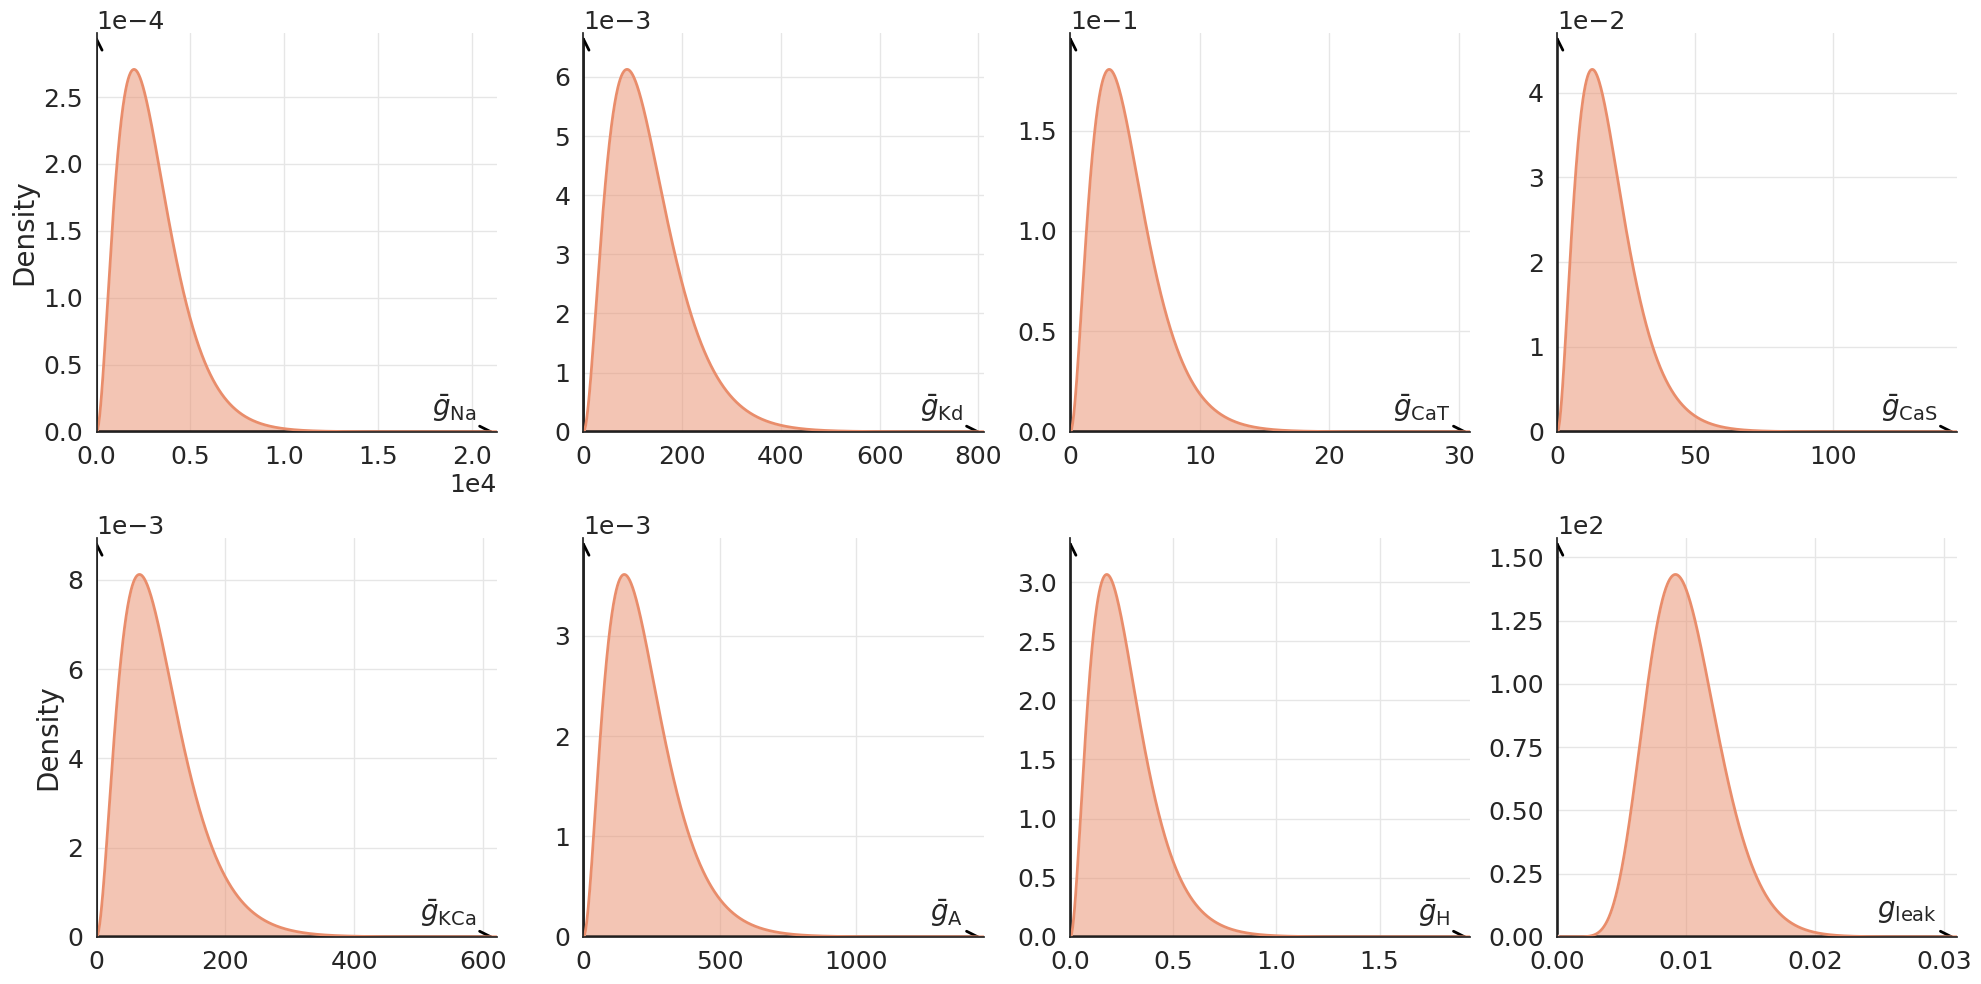

In [6]:
def plot_g_distributions():
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.flatten()

    for i, (ax, g, label, g_param) in enumerate(zip(axs, population.T, [
        r"$\bar{g}_{\text{Na}}$", 
        r"$\bar{g}_{\text{Kd}}$", 
        r"$\bar{g}_{\text{CaT}}$", 
        r"$\bar{g}_{\text{CaS}}$", 
        r"$\bar{g}_{\text{KCa}}$", 
        r"$\bar{g}_{\text{A}}$", 
        r"$\bar{g}_{\text{H}}$", 
        r"${g}_{\text{leak}}$"
    ], [
        g_Na_gamma_params,
        g_Kd_gamma_params,
        g_CaT_gamma_params,
        g_CaS_gamma_params,
        g_KCa_gamma_params,
        g_A_gamma_params,
        g_H_gamma_params,
        g_leak_gamma_params
    ])):   

        x = np.linspace(0, 1.1 * np.max(g), 1000)
        y = gamma.pdf(x, a=g_param[0], scale=g_param[1])
        ax.plot(x, y, lw=2)
        ax.fill_between(x, y, alpha=0.5)
        
        if i == 0 or i == 4:
            ax.set_ylabel('Density', fontsize=20)
        else:
            ax.set_ylabel('')
        
        ax.set_xlabel('')  # Remove the default x-label
        
        # Add the label above the x-axis to the right
        ax.text(0.95, 0.1, label, transform=ax.transAxes, ha='right', va='top', fontsize=20)
        
        ax.set_xlim(0, 1.1 * np.max(g))
        ax.set_ylim(0, 1.1 * np.max(y))
        
        # Force scientific notation for y-axis and x-axis
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_major_formatter(ScalarFormatter())
        
        # Enforce scientific notation for both axes
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-100,3.5))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
        # Set font size for tick labels including exponents
        ax.tick_params(axis='y', labelsize=18)  # Increase y-axis ticks fontsize
        ax.tick_params(axis='x', labelsize=18)  # Increase x-axis ticks fontsize
        ax.yaxis.offsetText.set_fontsize(18)
        ax.xaxis.offsetText.set_fontsize(18)
        
        ax.add_patch(FancyArrowPatch((0, 0), (1, 0), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=ax.transAxes))
        ax.add_patch(FancyArrowPatch((0, 0), (0, 1), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=ax.transAxes))

    plt.tight_layout()

    # Save as g_distribution.pdf
    plt.savefig("g_distributions.pdf")
    plt.show()

plot_g_distributions() # Figure 3

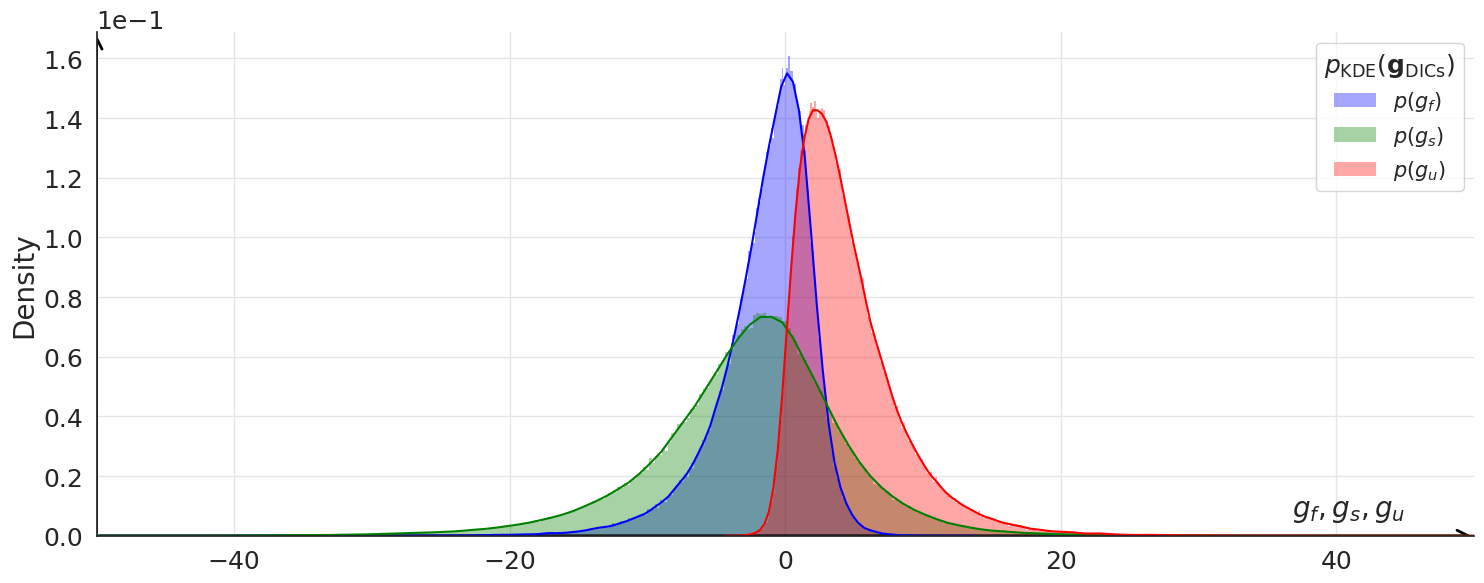

In [7]:
def plot_dics_distribution(dics):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))

    sns.histplot(dics[0, :], bins='auto', kde=True, ax=ax, stat="density", color="blue", alpha=0.35, linewidth=2, label=r"$p(g_f)$", edgecolor='none')
    sns.histplot(dics[1, :], bins='auto', kde=True, ax=ax, stat="density", color="green", alpha=0.35, linewidth=2, label=r"$p(g_s)$", edgecolor='none')
    sns.histplot(dics[2, :], bins='auto', kde=True, ax=ax, stat="density", color="red", alpha=0.35, linewidth=2, label=r"$p(g_u)$", edgecolor='none')

    ax.set_xlabel('', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.legend(title=r"$p_{\text{KDE}}(\mathbf{g}_{\text{DICs}})$", loc="upper right", fontsize=15, title_fontsize=18)

    ax.set_xlim(-50, 50)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax.text(0.95, 0.08, r"$g_f, g_s, g_u$", transform=ax.transAxes, ha='right', va='top', fontsize=20)

    ax.add_patch(FancyArrowPatch((0, 0), (1, 0), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=ax.transAxes))
    ax.add_patch(FancyArrowPatch((0, 0), (0, 1), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=ax.transAxes))

    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.yaxis.offsetText.set_fontsize(18)
    ax.xaxis.offsetText.set_fontsize(18)

    plt.tight_layout()
    plt.savefig("DICs_distribution.pdf")
    plt.show()

plot_dics_distribution(dics) # Figure 4

In [8]:
# build the KDE of the marginal
from scipy.stats import gaussian_kde

def build_marginal(dics):
    return gaussian_kde(dics[0, :]), gaussian_kde(dics[1, :]), gaussian_kde(dics[2, :])

f_kde, s_kde, u_kde = build_marginal(dics)

# print mean, std and a 95% confidence interval for each marginal
print("DICs marginals") # Table 1
print("f: ", f"{np.mean(dics[0, :]):.2f}", f"{np.std(dics[0, :]):.2f}", f"{np.percentile(dics[0, :], 2.5):.2f}", f"{np.percentile(dics[0, :], 97.5):.2f}")
print("s: ", f"{np.mean(dics[1, :]):.2f}", f"{np.std(dics[1, :]):.2f}", f"{np.percentile(dics[1, :], 2.5):.2f}", f"{np.percentile(dics[1, :], 97.5):.2f}")
print("u: ", f"{np.mean(dics[2, :]):.2f}", f"{np.std(dics[2, :]):.2f}", f"{np.percentile(dics[2, :], 2.5):.2f}", f"{np.percentile(dics[2, :], 97.5):.2f}")

DICs marginals
f:  -1.42 3.47 -9.98 3.54
s:  -2.61 7.01 -18.21 10.25
u:  4.54 3.83 -0.19 14.25


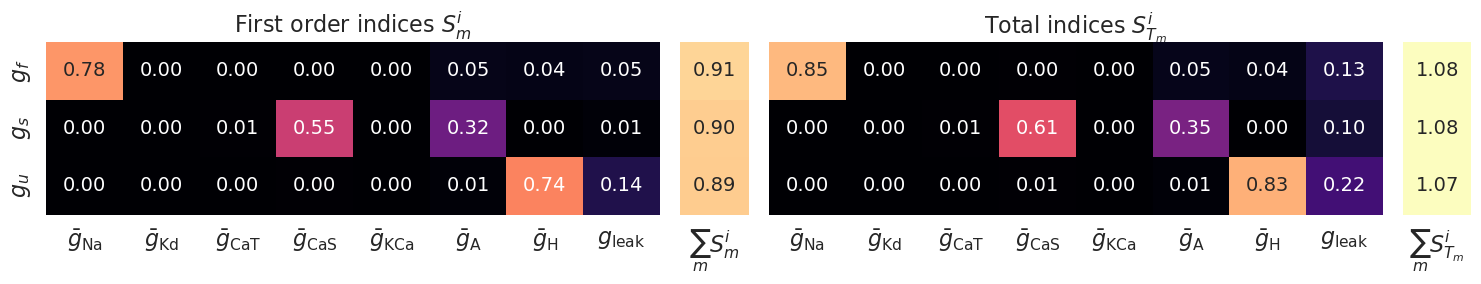

In [9]:
# We build SOBOL indices and total Sobol indices using saltelli method but implementing it from scratch

# USE get_a_virtual_population(n_cells) to generate the population (n_cells, 8)
# USE model(population) to generate the output (3, n_cells)

S_indices = sobol_indices(n_cells, population=population)

sum_first_order = S_indices[:, :, 0].sum(axis=1)
sum_total = S_indices[:, :, 1].sum(axis=1)
# make a plot of the sobol indices : two heat maps, first order and total indices
fig, ax = plt.subplots(1, 4, figsize=(15, 3), gridspec_kw={'width_ratios': [0.45, 0.05, 0.45, 0.05]}, sharey=True)
y_ticks = [r"$g_f$", r"$g_s$", r"$g_u$"]
x_ticks = [r"$\bar{g}_{\text{Na}}$", r"$\bar{g}_{\text{Kd}}$", r"$\bar{g}_{\text{CaT}}$", r"$\bar{g}_{\text{CaS}}$", r"$\bar{g}_{\text{KCa}}$", r"$\bar{g}_{\text{A}}$", r"$\bar{g}_{\text{H}}$", r"${g}_{\text{leak}}$"]
ax = ax.flatten()

# First order indices heatmap
sns.heatmap(S_indices[:, :, 0], annot=True, fmt=".2f", ax=ax[0], cmap="magma", cbar=False, vmin=0, vmax=1, annot_kws={"size": 14})
ax[0].set_title(r'First order indices $S^i_m$', fontsize=16)
ax[0].set_xlabel('', fontsize=16)
ax[0].set_ylabel('', fontsize=16)
ax[0].set_xticklabels(x_ticks, fontsize=16)
ax[0].set_yticklabels(y_ticks, fontsize=16)

# Sum of first order indices as column heat map
sns.heatmap(sum_first_order[:, None], annot=True, fmt=".2f", ax=ax[1], cmap="magma", cbar=False, vmin=0, vmax=1, annot_kws={"size": 14})
ax[1].set_xticklabels([r'$\sum_m S^i_m$'], fontsize=16)
ax[1].set_ylabel('', fontsize=12)

# Total indices heatmap
sns.heatmap(S_indices[:, :, 1], annot=True, fmt=".2f", ax=ax[2], cmap="magma", cbar=False, vmin=0, vmax=1, annot_kws={"size": 14})
ax[2].set_title(r'Total indices $S^i_{T_m}$', fontsize=16)
ax[2].set_xlabel('', fontsize=12)
ax[2].set_ylabel('', fontsize=12)
ax[2].set_xticklabels(x_ticks, fontsize=16)
ax[2].set_yticklabels(y_ticks, fontsize=16)

# Sum of total indices as column heat map
sns.heatmap(sum_total[:, None], annot=True, fmt=".2f", ax=ax[3], cmap="magma", cbar=False, vmin=0, vmax=1, annot_kws={"size": 14})
ax[3].set_xticklabels([r'$\sum_m S^i_{T_m}$'], fontsize=16)
ax[3].set_ylabel('', fontsize=18)
ax[3].set_yticklabels(y_ticks, fontsize=18)

plt.tight_layout()
# save as sobol_indices.pdf
plt.savefig("sobol_indices.pdf")
plt.show() # Table 2

# Convergence analysis

In [10]:
import concurrent.futures

number_of_population = 16
N_min = 100 
N_max = 300000
N_point = 150

# n_cells is exponentially spaced between N_min and N_max   
n_cells = np.unique(np.logspace(np.log10(N_min), np.log10(N_max), N_point).astype(int))
# force n_cells to be even
for i, n in enumerate(n_cells):
    if n % 2:
        n_cells[i] = n + 1

# We build the SOBOL indices for each population size
# We build the mean, std and 95% mass intervals of the output for each population size

S_indices_population = []
sum_S_indices_population = []
mean_dics_population = []
std_dics_population = []
bounds_95_mass_population = []

def process_population(j):
    S_indices = np.zeros((len(n_cells), 3, 8, 2))
    sum_S_indices = np.zeros((len(n_cells), 3, 2))
    mean_dics = np.zeros((len(n_cells), 3))
    std_dics = np.zeros((len(n_cells), 3))
    lower_bound_95_mass = np.zeros((len(n_cells), 3))
    upper_bound_95_mass = np.zeros((len(n_cells), 3))

    final_population = get_a_virtual_population(n_cells[-1], SEED=np.random.randint(0, 100000)+j)
    final_dics = model(final_population)

    for i, n in tqdm(enumerate(n_cells), total=len(n_cells), desc=f"Convergence analysis for population {j + 1}"):
        population = final_population[:n]
        dics = final_dics[:, :n]
        S_indices[i] = sobol_indices(n, population=population)
        sum_S_indices[i, :, 0] = S_indices[i, :, :, 0].sum(axis=1)
        sum_S_indices[i, :, 1] = S_indices[i, :, :, 1].sum(axis=1)
        mean_dics[i] = np.mean(dics, axis=1)
        std_dics[i] = np.std(dics, axis=1)
        lower_bound_95_mass[i] = np.percentile(dics, 2.5, axis=1)
        upper_bound_95_mass[i] = np.percentile(dics, 97.5, axis=1)

    bounds_95_mass = np.stack([lower_bound_95_mass, upper_bound_95_mass], axis=-1)

    return S_indices, sum_S_indices, mean_dics, std_dics, bounds_95_mass

with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    results = list(executor.map(process_population, range(number_of_population)))

for result in results:
    S_indices, sum_S_indices, mean_dics, std_dics, bounds_95_mass = result
    S_indices_population.append(S_indices)
    sum_S_indices_population.append(sum_S_indices)
    mean_dics_population.append(mean_dics)
    std_dics_population.append(std_dics)
    bounds_95_mass_population.append(bounds_95_mass)

# We compute the mean of each estimators over the populations
# We compute the std of each estimators over the populations
# We build plot of running mean +- std for each estimators
## A first (1x3) plot about mean_dics_population, std_dics_population, bounds_95_mass_population
## A second (1x2) plot about sum_S_indices_population[:, :, 0], sum_S_indices_population[:, :, 1]

S_indices_population = np.array(S_indices_population)
sum_S_indices_population = np.array(sum_S_indices_population)
mean_dics_population = np.array(mean_dics_population)
std_dics_population = np.array(std_dics_population)
bounds_95_mass_population = np.array(bounds_95_mass_population)

Convergence analysis for population 2: 100%|██████████| 150/150 [02:08<00:00,  1.17it/s]


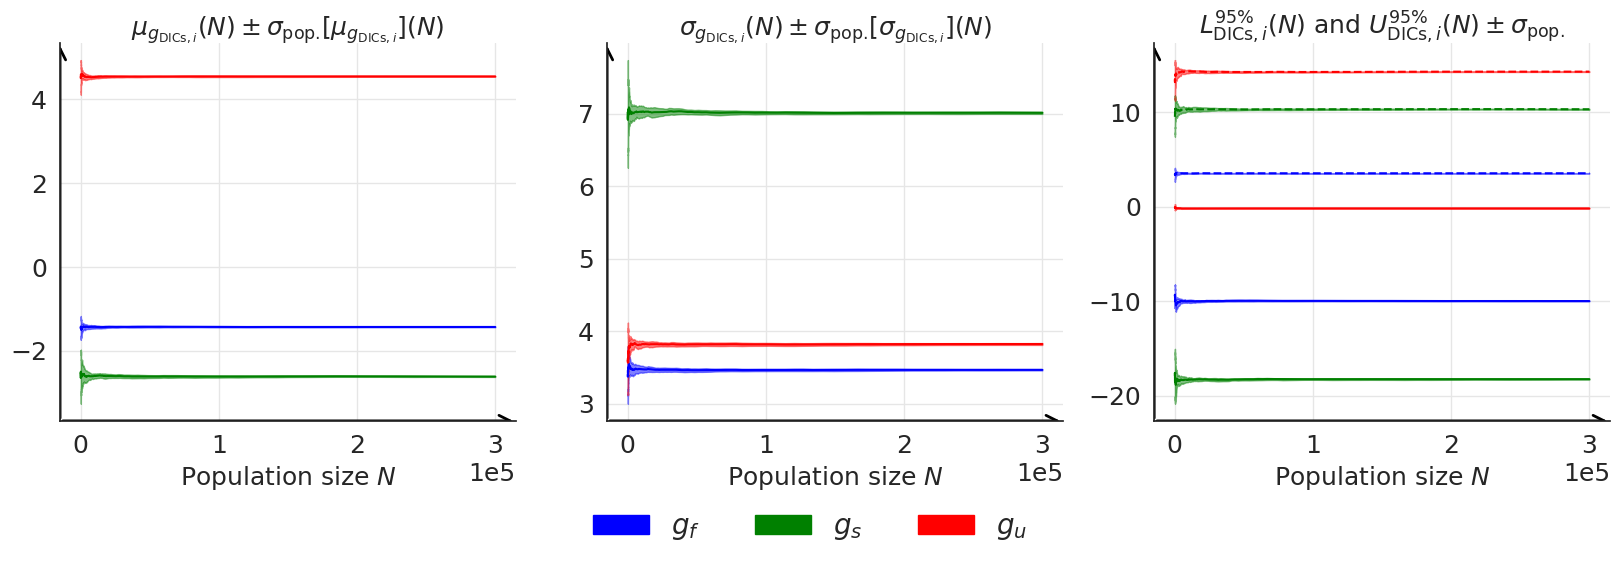

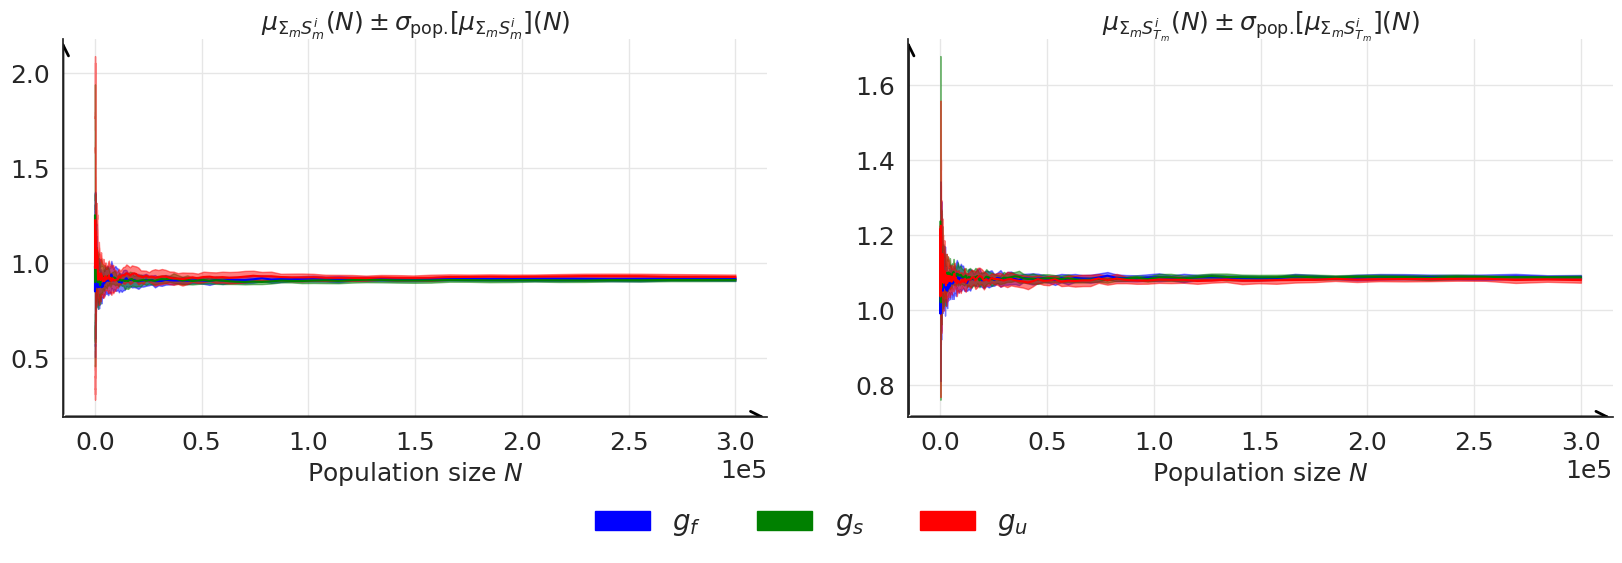

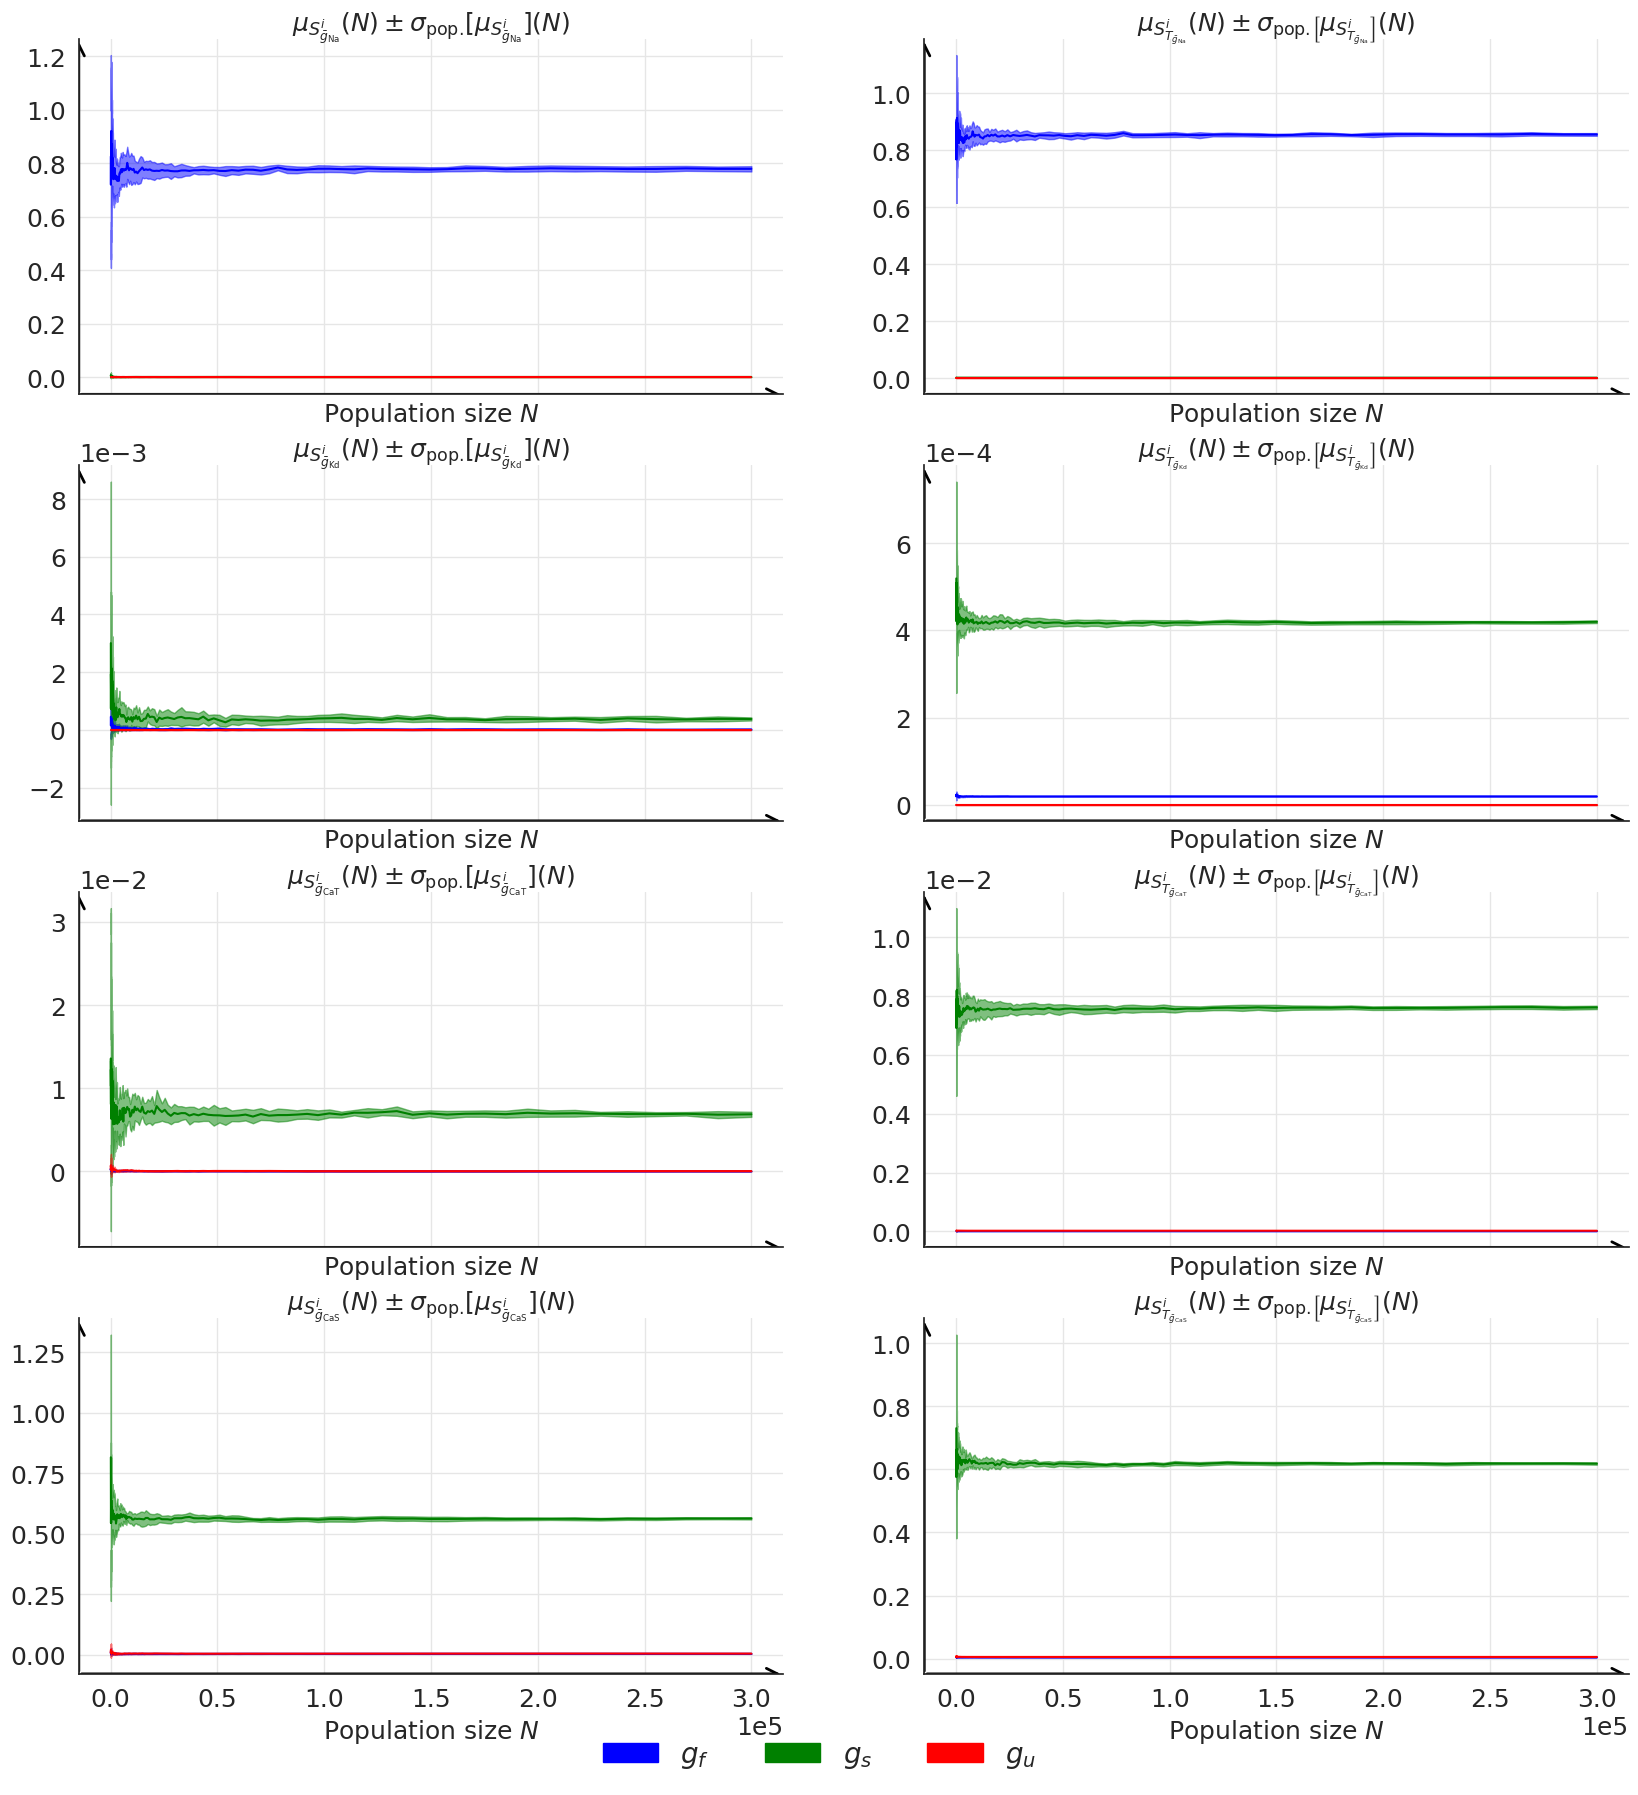

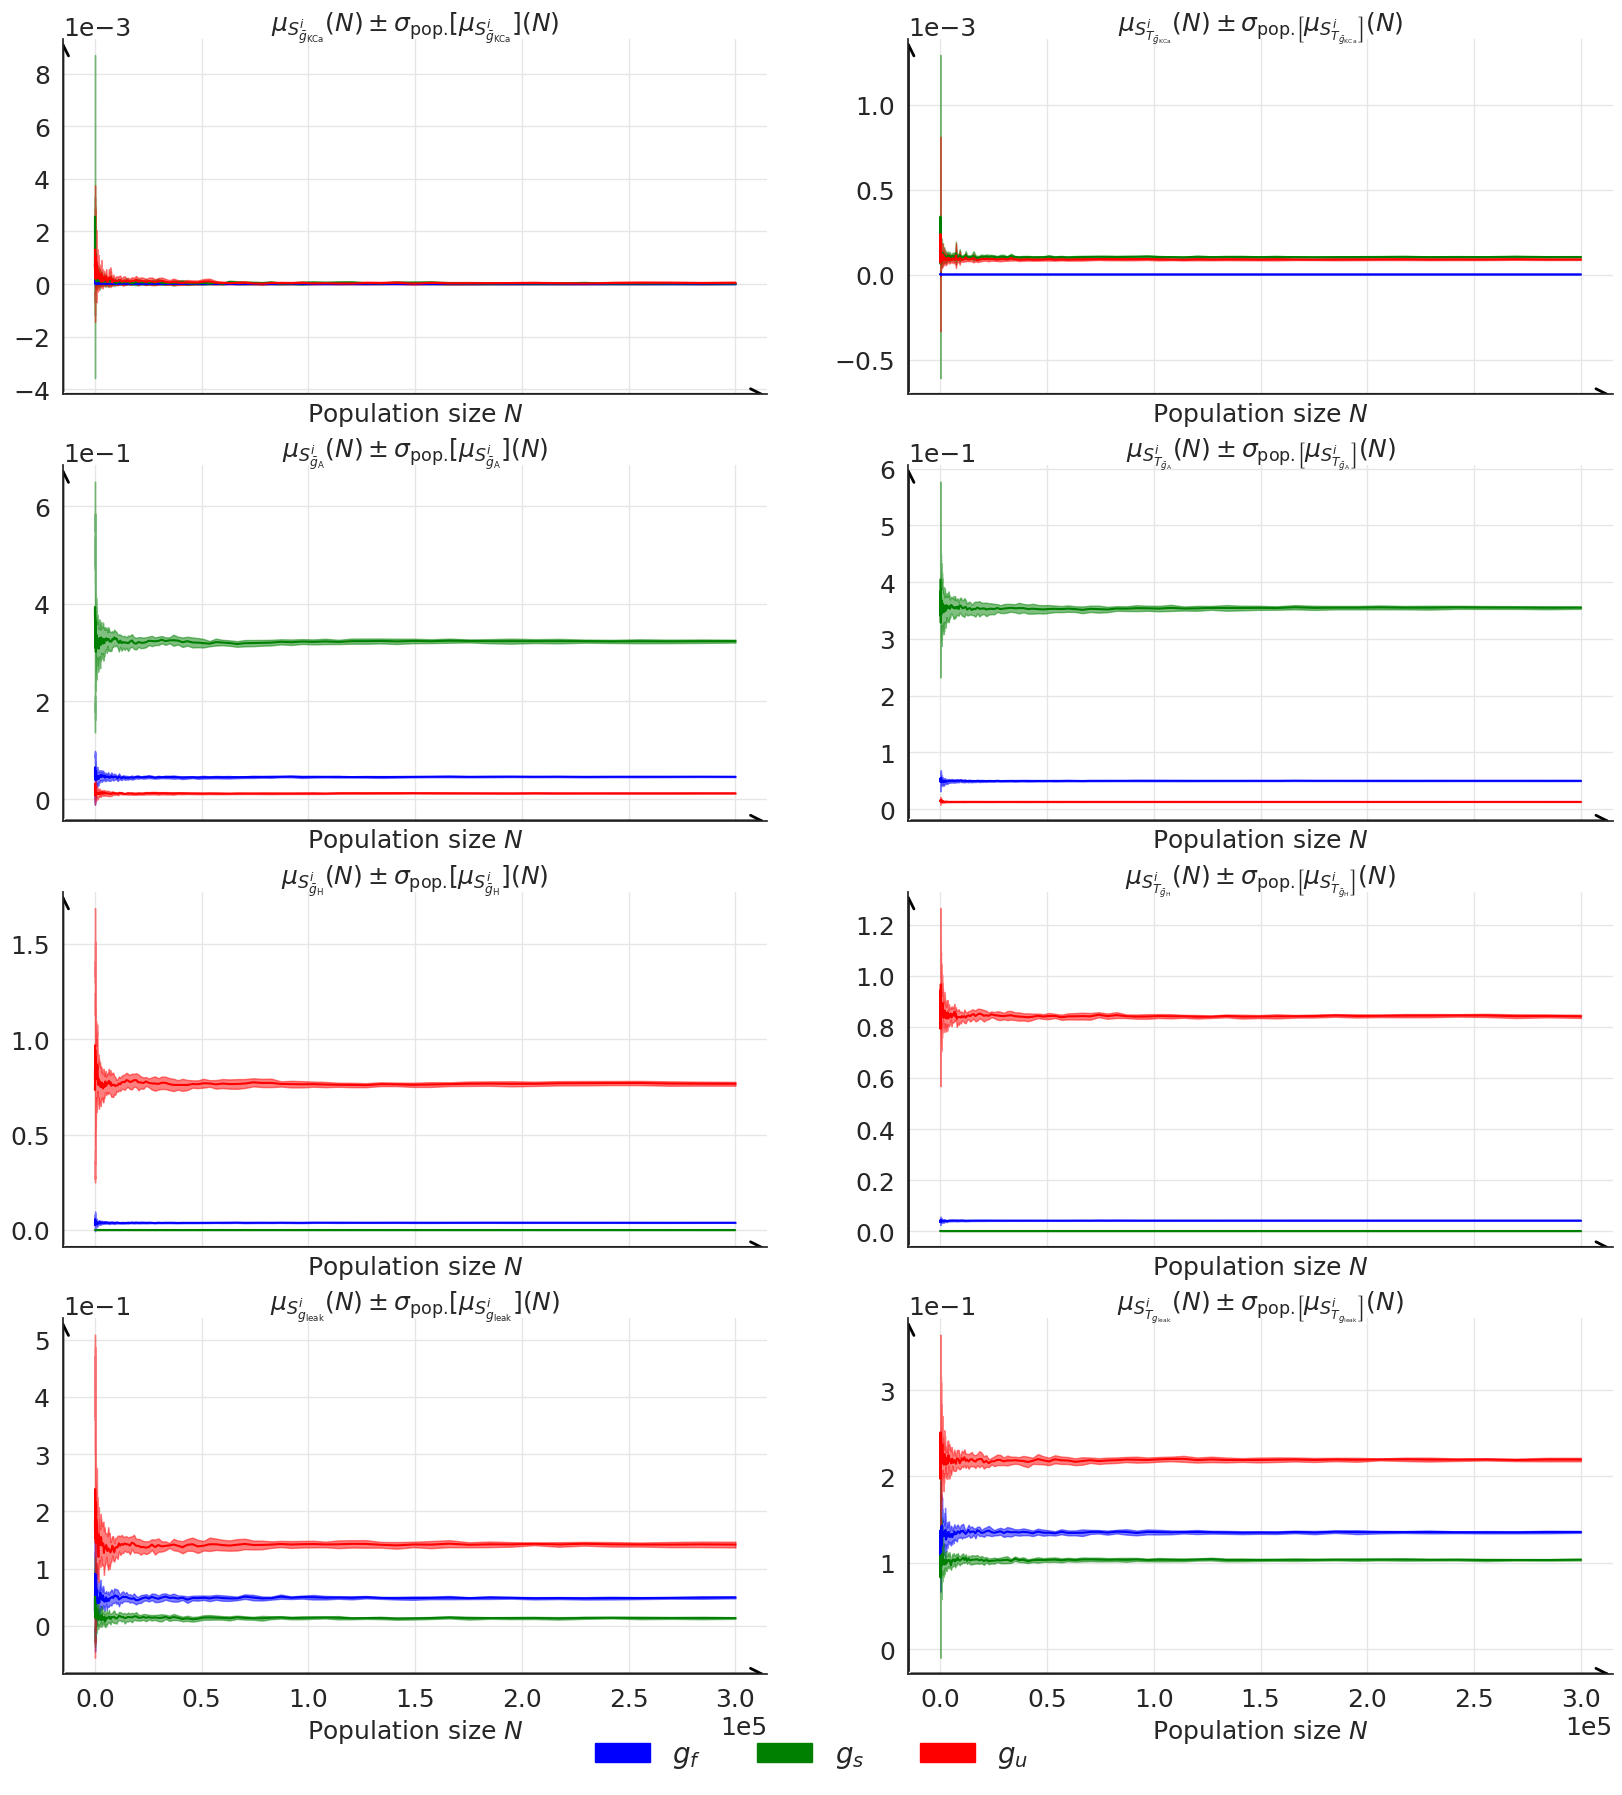

In [11]:
mean_S_indices_population = S_indices_population.mean(axis=0)
std_S_indices_population = S_indices_population.std(axis=0)
mean_sum_S_indices_population = sum_S_indices_population.mean(axis=0)
std_sum_S_indices_population = sum_S_indices_population.std(axis=0)
mean_mean_dics_population = mean_dics_population.mean(axis=0)
std_mean_dics_population = mean_dics_population.std(axis=0)
mean_std_dics_population = std_dics_population.mean(axis=0)
std_std_dics_population = std_dics_population.std(axis=0)
mean_bounds_95_mass_population = bounds_95_mass_population.mean(axis=0)
std_bounds_95_mass_population = bounds_95_mass_population.std(axis=0)

import matplotlib.patches as mpatches
def plot_with_error(ax, x, y_mean, y_std, colors, labels, xlabel, title, y_sci=False):
    for i, color in enumerate(colors):
        ax.plot(x, y_mean[:, i], color=color)
        ax.fill_between(x, y_mean[:, i] - y_std[:, i], y_mean[:, i] + y_std[:, i], alpha=0.5, color=color)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_title(title, fontsize=18)
    ax.add_patch(FancyArrowPatch((0, 0), (1, 0), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=ax.transAxes))
    ax.add_patch(FancyArrowPatch((0, 0), (0, 1), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=ax.transAxes))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    if y_sci:
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.yaxis.offsetText.set_fontsize(18)
    ax.xaxis.offsetText.set_fontsize(18)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs = axs.flatten()

# Plot for Mean of DICs
plot_with_error(axs[0], n_cells, mean_mean_dics_population, std_mean_dics_population, ["blue", "green", "red"], 
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$", 
                r"$\mu_{g_{\text{DICs}, i}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{g_{\text{DICs}, i}}\right](N)$")

# Plot for Standard Deviation of DICs
plot_with_error(axs[1], n_cells, mean_std_dics_population, std_std_dics_population, ["blue", "green", "red"], 
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$", 
                r"$\sigma_{g_{\text{DICs}, i}}(N) \pm \sigma_{\text{pop.}}\left[\sigma_{g_{\text{DICs}, i}}\right](N)$")

# Plot for 95% Mass Interval of DICs
for i, color in enumerate(["blue", "green", "red"]):
    axs[2].plot(n_cells, mean_bounds_95_mass_population[:, i, 0], color=color)
    axs[2].fill_between(n_cells, mean_bounds_95_mass_population[:, i, 0] - std_bounds_95_mass_population[:, i, 0], 
                        mean_bounds_95_mass_population[:, i, 0] + std_bounds_95_mass_population[:, i, 0], alpha=0.5, color=color)
    axs[2].plot(n_cells, mean_bounds_95_mass_population[:, i, 1], color=color, linestyle="--")
    axs[2].fill_between(n_cells, mean_bounds_95_mass_population[:, i, 1] - std_bounds_95_mass_population[:, i, 1], 
                        mean_bounds_95_mass_population[:, i, 1] + std_bounds_95_mass_population[:, i, 1], alpha=0.5, color=color)
axs[2].set_xlabel(r"Population size $N$", fontsize=18)
axs[2].set_title(r"$L^{95\%}_{\text{DICs}, i}(N)$ and $U^{95\%}_{\text{DICs}, i}(N) \pm \sigma_{\text{pop.}}$", fontsize=18)
axs[2].add_patch(FancyArrowPatch((0, 0), (1, 0), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=axs[2].transAxes))
axs[2].add_patch(FancyArrowPatch((0, 0), (0, 1), mutation_scale=20, color='black', lw=2, arrowstyle='->', transform=axs[2].transAxes))
axs[2].xaxis.set_major_formatter(ScalarFormatter())
axs[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[2].tick_params(axis='y', labelsize=18)
axs[2].tick_params(axis='x', labelsize=18)
axs[2].yaxis.offsetText.set_fontsize(18)
axs[2].xaxis.offsetText.set_fontsize(18)

# Adjust layout to make space for the shared legend
plt.subplots_adjust(bottom=0.25)  # Add space at the bottom

# Shared Legend with Filled Rectangles
patches = [mpatches.Patch(color="blue", label=r"$g_f$"),
           mpatches.Patch(color="green", label=r"$g_s$"),
           mpatches.Patch(color="red", label=r"$g_u$")]
fig.legend(handles=patches, loc="lower center", fontsize=20, ncol=3, frameon=False)

plt.savefig("convergence_analysis_table1.pdf", bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()

# Plot for Sum of First Order Indices
plot_with_error(axs[0], n_cells, mean_sum_S_indices_population[:, :, 0], std_sum_S_indices_population[:, :, 0], ["blue", "green", "red"], 
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$", 
                r"$\mu_{\Sigma_m S^i_m}(N) \pm \sigma_{\text{pop.}}\left[\mu_{\Sigma_m S^i_m}\right](N)$")

# Plot for Sum of Total Indices
plot_with_error(axs[1], n_cells, mean_sum_S_indices_population[:, :, 1], std_sum_S_indices_population[:, :, 1], ["blue", "green", "red"], 
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$", 
                r"$\mu_{\Sigma_m S^i_{T_m}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{\Sigma_m S^i_{T_m}}\right](N)$")

# Adjust layout to make space for the shared legend
plt.subplots_adjust(bottom=0.25)  # Add space at the bottom

# Shared Legend with Filled Rectangles
patches = [mpatches.Patch(color="blue", label=r"$g_f$"),
           mpatches.Patch(color="green", label=r"$g_s$"),
           mpatches.Patch(color="red", label=r"$g_u$")]
fig.legend(handles=patches, loc="lower center", fontsize=20, ncol=3, frameon=False)

plt.savefig("convergence_analysis_table2.pdf", bbox_inches="tight")
plt.show()

# == appendix figure ==

# We make a (8x2) plot of the convergence of all the SOBOL indices using the plot_with_error function
## First col plot is the first order indices
## Second col plot is the total indices
# First file (4x2) plot
fig, axs = plt.subplots(4, 2, figsize=(20, 20), sharex=True)
axs = axs.flatten()
plot_with_error(axs[0], n_cells, mean_S_indices_population[:, :, 0, 0], std_S_indices_population[:, :, 0, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{\bar{g}_{\text{Na}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{\bar{g}_{\text{Na}}}}\right](N)$", y_sci=True)

plot_with_error(axs[1], n_cells, mean_S_indices_population[:, :, 0, 1], std_S_indices_population[:, :, 0, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{\bar{g}_{\text{Na}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{\bar{g}_{\text{Na}}}}}\right](N)$", y_sci=True)

plot_with_error(axs[2], n_cells, mean_S_indices_population[:, :, 1, 0], std_S_indices_population[:, :, 1, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{\bar{g}_{\text{Kd}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{\bar{g}_{\text{Kd}}}}\right](N)$", y_sci=True)

plot_with_error(axs[3], n_cells, mean_S_indices_population[:, :, 1, 1], std_S_indices_population[:, :, 1, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{\bar{g}_{\text{Kd}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{\bar{g}_{\text{Kd}}}}}\right](N)$", y_sci=True)

plot_with_error(axs[4], n_cells, mean_S_indices_population[:, :, 2, 0], std_S_indices_population[:, :, 2, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{\bar{g}_{\text{CaT}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{\bar{g}_{\text{CaT}}}}\right](N)$", y_sci=True)

plot_with_error(axs[5], n_cells, mean_S_indices_population[:, :, 2, 1], std_S_indices_population[:, :, 2, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{\bar{g}_{\text{CaT}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{\bar{g}_{\text{CaT}}}}}\right](N)$", y_sci=True)

plot_with_error(axs[6], n_cells, mean_S_indices_population[:, :, 3, 0], std_S_indices_population[:, :, 3, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{\bar{g}_{\text{CaS}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{\bar{g}_{\text{CaS}}}}\right](N)$", y_sci=True)

plot_with_error(axs[7], n_cells, mean_S_indices_population[:, :, 3, 1], std_S_indices_population[:, :, 3, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{\bar{g}_{\text{CaS}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{\bar{g}_{\text{CaS}}}}}\right](N)$", y_sci=True)

# Adjust layout to make space for the shared legend
plt.subplots_adjust(bottom=0.25/4)  # Add space at the bottom

# Shared Legend with Filled Rectangles
patches = [mpatches.Patch(color="blue", label=r"$g_f$"),
           mpatches.Patch(color="green", label=r"$g_s$"),
           mpatches.Patch(color="red", label=r"$g_u$")]
fig.legend(handles=patches, loc="lower center", fontsize=20, ncol=3, frameon=False)

plt.savefig("convergence_analysis_appendix_part1.pdf", bbox_inches="tight")
plt.show()

# Second file (4x2) plot
fig, axs = plt.subplots(4, 2, figsize=(20, 20), sharex=True)
axs = axs.flatten()
plot_with_error(axs[0], n_cells, mean_S_indices_population[:, :, 4, 0], std_S_indices_population[:, :, 4, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{\bar{g}_{\text{KCa}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{\bar{g}_{\text{KCa}}}}\right](N)$", y_sci=True)

plot_with_error(axs[1], n_cells, mean_S_indices_population[:, :, 4, 1], std_S_indices_population[:, :, 4, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{\bar{g}_{\text{KCa}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{\bar{g}_{\text{KCa}}}}}\right](N)$", y_sci=True)

plot_with_error(axs[2], n_cells, mean_S_indices_population[:, :, 5, 0], std_S_indices_population[:, :, 5, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{\bar{g}_{\text{A}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{\bar{g}_{\text{A}}}}\right](N)$", y_sci=True)

plot_with_error(axs[3], n_cells, mean_S_indices_population[:, :, 5, 1], std_S_indices_population[:, :, 5, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{\bar{g}_{\text{A}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{\bar{g}_{\text{A}}}}}\right](N)$", y_sci=True)

plot_with_error(axs[4], n_cells, mean_S_indices_population[:, :, 6, 0], std_S_indices_population[:, :, 6, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{\bar{g}_{\text{H}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{\bar{g}_{\text{H}}}}\right](N)$", y_sci=True)

plot_with_error(axs[5], n_cells, mean_S_indices_population[:, :, 6, 1], std_S_indices_population[:, :, 6, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{\bar{g}_{\text{H}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{\bar{g}_{\text{H}}}}}\right](N)$", y_sci=True)

plot_with_error(axs[6], n_cells, mean_S_indices_population[:, :, 7, 0], std_S_indices_population[:, :, 7, 0], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{g_{\text{leak}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{g_{\text{leak}}}}\right](N)$", y_sci=True)

plot_with_error(axs[7], n_cells, mean_S_indices_population[:, :, 7, 1], std_S_indices_population[:, :, 7, 1], ["blue", "green", "red"],
                [r"$g_f$", r"$g_s$", r"$g_u$"], r"Population size $N$",
                r"$\mu_{S^i_{T_{g_{\text{leak}}}}}(N) \pm \sigma_{\text{pop.}}\left[\mu_{S^i_{T_{g_{\text{leak}}}}}\right](N)$", y_sci=True)

# Adjust layout to make space for the shared legend
plt.subplots_adjust(bottom=0.25/4)  # Add space at the bottom

# Shared Legend with Filled Rectangles
patches = [mpatches.Patch(color="blue", label=r"$g_f$"),
           mpatches.Patch(color="green", label=r"$g_s$"),
           mpatches.Patch(color="red", label=r"$g_u$")]
fig.legend(handles=patches, loc="lower center", fontsize=20, ncol=3, frameon=False)

plt.savefig("convergence_analysis_appendix_part2.pdf", bbox_inches="tight")
plt.show()



In [12]:
# print all the final std of the estimators
print("Final std of the estimators") # Table 4
print("Mean of DICs: ", std_mean_dics_population[-1])
print("Std of DICs: ", std_std_dics_population[-1])
print("95% Mass Interval of DICs: ", std_bounds_95_mass_population[-1])
print("Sum of First Order Indices: ", std_sum_S_indices_population[-1, :, 0])
print("Sum of Total Indices: ", std_sum_S_indices_population[-1, :, 1])
print("First order indices: ", std_S_indices_population[-1, :, :, 0].T)
print("Total indices: ", std_S_indices_population[-1, :, :, 1].T)

Final std of the estimators
Mean of DICs:  [0.00606048 0.0095158  0.00682934]
Std of DICs:  [0.00767816 0.01468103 0.01271273]
95% Mass Interval of DICs:  [[0.01771018 0.01429623]
 [0.04340132 0.04357357]
 [0.00625522 0.03619684]]
Sum of First Order Indices:  [0.01083063 0.00602465 0.01280309]
Sum of Total Indices:  [0.00553287 0.00453392 0.00698282]
First order indices:  [[9.77997125e-03 1.14471213e-04 0.00000000e+00]
 [1.63168494e-05 5.28015399e-05 0.00000000e+00]
 [9.07348444e-06 3.07538535e-04 2.31424157e-05]
 [2.71338282e-04 4.29280994e-03 4.37786133e-04]
 [3.15217100e-06 2.17302498e-05 3.98352898e-05]
 [6.87176567e-04 2.97947634e-03 6.08431667e-04]
 [5.24693672e-04 0.00000000e+00 1.02041388e-02]
 [1.69648921e-03 1.41436482e-03 5.04259203e-03]]
Total indices:  [[4.73400600e-03 9.66089605e-06 0.00000000e+00]
 [2.37362994e-07 2.95074092e-06 0.00000000e+00]
 [1.04646574e-07 5.68957167e-05 2.40333058e-07]
 [3.71298441e-05 3.50997132e-03 5.46872729e-05]
 [6.90630333e-08 3.02513173e-06 